Loading packages and data

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import trompy as tp
from scipy import stats

In [2]:
# read in data
PATH_TO_WORKBOOK = Path("../data/")
EXCEL_WORKBOOK = "measurements_b3_2.xlsx"
rows, header = tp.metafilereader(PATH_TO_WORKBOOK / EXCEL_WORKBOOK, sheetname="metafile_niacin_2")

grouping the animals and exploring the data frame

In [3]:
def get_value(row):
    if row['sex'] == 'female' and row['diet'] == 'control' and row['sucrose'] == 'Yes':
        return 0
    elif row['sex'] == 'female' and row['diet'] == 'control' and row['sucrose'] == 'No':
        return 1
    elif row['sex'] == 'female' and row['diet'] == 'experimental' and row['sucrose'] == 'Yes':
        return 2
    elif row['sex'] == 'female' and row['diet'] == 'experimental' and row['sucrose'] == 'No':
        return 3
    elif row['sex'] == 'male' and row['diet'] == 'control' and row['sucrose'] == 'Yes':
        return 4
    elif row['sex'] == 'male' and row['diet'] == 'control' and row['sucrose'] == 'No':
        return 5
    elif row['sex'] == 'male' and row['diet'] == 'experimental' and row['sucrose'] == 'Yes':
        return 6
    elif row['sex'] == 'male' and row['diet'] == 'experimental' and row['sucrose'] == 'No':
        return 7
    else:
        return -1

def tweak_df(df):
    
    return (df
            # .query("bodyweight != ''")
            .query("bodyweight.notna()", engine="python")
            .astype({"sex": "category",
                     "diet": "category",
                     "date": object, 
                     "bodyweight": float,
                     "food_yesterday": float,
                     "food_intake": float,
                     "sucrose_intake": float
                     }
                    )
             .assign(groupn = lambda df_: df_.apply(get_value, axis=1))
            )
    
df = tweak_df(pd.DataFrame(rows, columns=header))

In [4]:
df

,animal_id,sex,diet,date,sucrose,bodyweight,food_yesterday,food_today,food_intake,sucrose_yesterday,sucrose_today,sucrose_intake,groupn
0,B3201,female,control,2024-04-06 00:00:00,No,20.6,-1.0,80.8,-1.000000,-1.0,-1.0,-1.000000,1
1,B3202,female,control,2024-04-06 00:00:00,No,21.0,-1.0,98.6,-1.000000,-1.0,-1.0,-1.000000,1
2,B3203,female,experimental,2024-04-06 00:00:00,No,21.2,-1.0,139.3,-1.000000,-1.0,-1.0,-1.000000,3
3,B3204,female,experimental,2024-04-06 00:00:00,No,20.4,-1.0,139.3,-1.000000,-1.0,-1.0,-1.000000,3
4,B3205,female,control,2024-04-06 00:00:00,No,19.8,-1.0,80.2,-1.000000,-1.0,-1.0,-1.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,B3244,male,experimental,2024-04-15 00:00:00,No,25.0,71.7,63.4,2.766667,-1.0,-1.0,-1.000000,7
188,B3245,male,experimental,2024-04-15 00:00:00,No,24.7,46.5,37.3,3.066667,-1.0,-1.0,-1.000000,7
189,B3246,male,experimental,2024-04-15 00:00:00,No,26.6,69.8,60.2,3.200000,-1.0,-1.0,-1.000000,7
190,B3247,male,experimental,2024-04-15 00:00:00,Yes,26.2,65.1,61.3,1.266667,55.2,37.2,6.000000,6


In [5]:
df.dtypes

animal_id              object
sex                  category
diet                 category
date                   object
sucrose                object
bodyweight            float64
food_yesterday        float64
food_today            float64
food_intake           float64
sucrose_yesterday     float64
sucrose_today         float64
sucrose_intake        float64
groupn                  int64
dtype: object

In [6]:
df.columns

Index(['animal_id', 'sex', 'diet', 'date', 'sucrose', 'bodyweight',
       'food_yesterday', 'food_today', 'food_intake', 'sucrose_yesterday',
       'sucrose_today', 'sucrose_intake', 'groupn'],
      dtype='object')

In [7]:
df.animal_id.unique()
df.date.unique()

array([Timestamp('2024-04-06 00:00:00'), Timestamp('2024-04-09 00:00:00'),
       Timestamp('2024-04-12 00:00:00'), Timestamp('2024-04-15 00:00:00')],
      dtype=object)

In [8]:
df.groupby(["sex", "diet", "date"]).mean(numeric_only=True).reset_index()

,sex,diet,date,bodyweight,food_yesterday,food_today,food_intake,sucrose_yesterday,sucrose_today,sucrose_intake,groupn
0,female,control,2024-04-06,20.625000,-1.000000,79.458333,-1.000000,-1.000000,-1.000000,-1.000000,1.0
1,female,control,2024-04-09,20.466667,79.458333,69.700000,2.752778,-1.000000,-1.000000,-1.000000,1.0
2,female,control,2024-04-12,20.858333,69.700000,59.250000,2.969444,-1.000000,26.783333,-1.000000,0.5
3,female,control,2024-04-15,21.158333,59.250000,50.641667,2.347222,26.783333,19.233333,2.016667,0.5
4,female,experimental,2024-04-06,20.725000,-1.000000,87.141667,-1.000000,-1.000000,-1.000000,-1.000000,3.0
5,female,experimental,2024-04-09,20.733333,87.141667,77.216667,2.869444,-1.000000,-1.000000,-1.000000,3.0
6,female,experimental,2024-04-12,21.483333,77.216667,66.316667,3.158333,-1.000000,26.850000,-1.000000,2.5
7,female,experimental,2024-04-15,21.925000,66.316667,57.983333,2.300000,26.850000,17.675000,2.558333,2.5
8,male,control,2024-04-06,25.716667,-1.000000,63.650000,-1.000000,-1.000000,-1.000000,-1.000000,5.0
9,male,control,2024-04-09,25.608333,63.650000,54.050000,3.200000,-1.000000,-1.000000,-1.000000,5.0


In [9]:
# remove outliers
# is done by creating the new dataframe df_food_water
# Clean up df


def replace_outliers(df, column):
    
    values=[]
    for idx, row in df.iterrows():
        if row[column] < 1:
            values.append(np.nan)
        elif row[column] > np.mean(df[column]) * 2:
            values.append(np.nan)
        else:
            values.append(row[column])
    
    print("the number of outliers being replaced for", column, "is", np.sum(np.isnan(values)))
    df[column] = values
    mean_by_animal = df.groupby(["animal_id"]).mean(numeric_only=True).reset_index()
            
    values=[]
    for idx, row in df.iterrows():
        if np.isnan(row[column]):
            values.append(mean_by_animal.query('animal_id == @row.animal_id')[column].values[0])
        else:
            values.append(row[column])
    
    return values
    
def remove_and_clean(df):
    """Removes unecessary rows and cleans data to get rid of erroneous values.

    Args:
        df (Pandas dataframe): Contains data from niacin experiment

    Returns:
        Dataframe: Cleaned dataframe
    """
    return (df
            .query("food_yesterday != -1.0")
            
            .assign(food_intake = lambda df_: replace_outliers(df_, "food_intake"))
            
    )

df_food_water = remove_and_clean(df)

# need function to replace sucrose leak values with something reasonable

the number of outliers being replaced for food_intake is 1
the number of outliers being replaced for sucrose_intake is 144


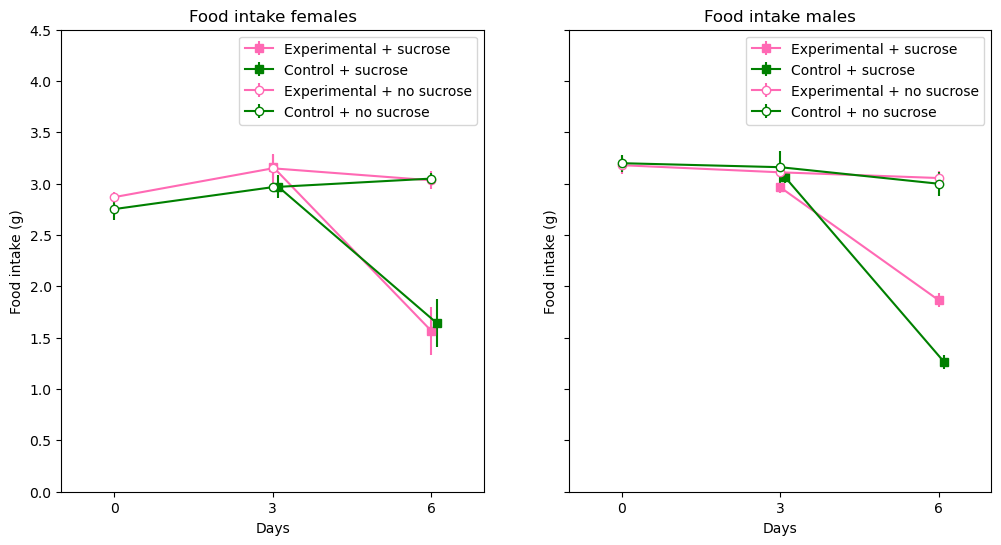

In [62]:
# Find mean and SEM of all data - food intake
mean_fw = df_food_water.groupby(["sex", "diet", "sucrose", "date"]).mean(numeric_only=True).reset_index()
sem_fw = df_food_water.groupby(["sex", "diet", "sucrose","date"]).sem(numeric_only=True).reset_index()

# Generate figure with two subplots
f, ax = plt.subplots(ncols=2, figsize=(12, 6), sharey=True,
                     gridspec_kw={"width_ratios": [1, 1]},)

# Females

# Set x values
x = np.arange(0, len(mean_fw.query("sex == 'female' and sucrose == 'Yes' and diet == 'experimental'"))*3, 3)
x = np.arange(0, len(mean_fw.query("sex == 'female' and sucrose == 'Yes' and diet == 'experimental'"))*3, 3)
x = [0,3,6]

# Plot data for each group in first subplot
ax[0].errorbar(x,
               mean_fw.query("sex == 'female' and sucrose == 'Yes' and diet == 'experimental'").food_intake,
               yerr=sem_fw.query("sex == 'female' and sucrose =='Yes' and diet == 'control'").food_intake,
               marker="s", markerfacecolor="hotpink", color="hotpink",
               label="Experimental + sucrose"
              )

ax[0].errorbar([xval + 0.1 for xval in x],
               mean_fw.query("sex == 'female' and sucrose == 'Yes' and diet == 'control'").food_intake,
               yerr=sem_fw.query("sex == 'female' and sucrose =='Yes' and diet == 'control'").food_intake,
               marker="s", markerfacecolor="green", color="green",
               label="Control + sucrose"
              )

ax[0].errorbar(x,
               mean_fw.query("sex == 'female' and sucrose == 'No' and diet == 'experimental'").food_intake,
               yerr=sem_fw.query("sex == 'female' and sucrose == 'No' and diet == 'experimental'").food_intake,
               marker="o", markerfacecolor="white", color="hotpink",
               label="Experimental + no sucrose"
              )

ax[0].errorbar(x,
               mean_fw.query("sex == 'female' and sucrose == 'No' and diet == 'control'").food_intake,
               yerr=sem_fw.query("sex == 'female' and sucrose == 'No' and diet == 'control'").food_intake,
               marker="o", markerfacecolor="white", color="green",
               label="Control + no sucrose"
              )

# Set x axis limits and ticks
ax[0].set_xlim([-1, x[-1]+1])
ax[0].set_xticks(np.arange(0, x[-1]+1, 3)) 
ax[0].set_ylim([0, 4.5])

# Add labels
ax[0].set_ylabel("Food intake (g)")
ax[0].set_xlabel("Days")
ax[0].legend()
ax[0].set_title("Food intake females")



# Males
x = np.arange(0, len(mean_fw.query("sex == 'male' and sucrose == 'Yes' and diet == 'experimental'"))*3, 3)
x = np.arange(0, len(mean_fw.query("sex == 'male' and sucrose == 'Yes' and diet == 'experimental'"))*3, 3)
x = [0,3,6]

# Plot data for each group in first subplot
ax[1].errorbar(x,
               mean_fw.query("sex == 'male' and sucrose == 'Yes' and diet == 'experimental'").food_intake,
               yerr=sem_fw.query("sex == 'male' and sucrose =='Yes' and diet == 'control'").food_intake,
               marker="s", markerfacecolor="hotpink", color="hotpink",
               label="Experimental + sucrose"
              )

ax[1].errorbar([xval + 0.1 for xval in x],
               mean_fw.query("sex == 'male' and sucrose == 'Yes' and diet == 'control'").food_intake,
               yerr=sem_fw.query("sex == 'male' and sucrose =='Yes' and diet == 'control'").food_intake,
               marker="s", markerfacecolor="green", color="green",
               label="Control + sucrose"
              )

ax[1].errorbar(x,
               mean_fw.query("sex == 'male' and sucrose == 'No' and diet == 'experimental'").food_intake,
               yerr=sem_fw.query("sex == 'male' and sucrose == 'No' and diet == 'experimental'").food_intake,
               marker="o", markerfacecolor="white", color="hotpink",
               label="Experimental + no sucrose"
              )

ax[1].errorbar(x,
               mean_fw.query("sex == 'male' and sucrose == 'No' and diet == 'control'").food_intake,
               yerr=sem_fw.query("sex == 'male' and sucrose == 'No' and diet == 'control'").food_intake,
               marker="o", markerfacecolor="white", color="green",
               label="Control + no sucrose"
              )

# Set x axis limits and ticks
ax[1].set_xlim([-1, x[-1]+1])
ax[1].set_xticks(np.arange(0, x[-1]+1, 3)) 
ax[1].set_ylim([0, 4.5])

# Add labels
ax[1].set_ylabel("Food intake (g)")
ax[1].set_xlabel("Days")
ax[1].legend()
ax[1].set_title("Food intake males")


f.savefig("..//results//foodintake.png")

In [50]:
## for when you kinda want the dots/datapoints of the graph not to overlap, add this to some of them
## use it instead of the x at the errorbar
[xval + 0.1 for xval in x]

[0.1, 3.1, 6.1]

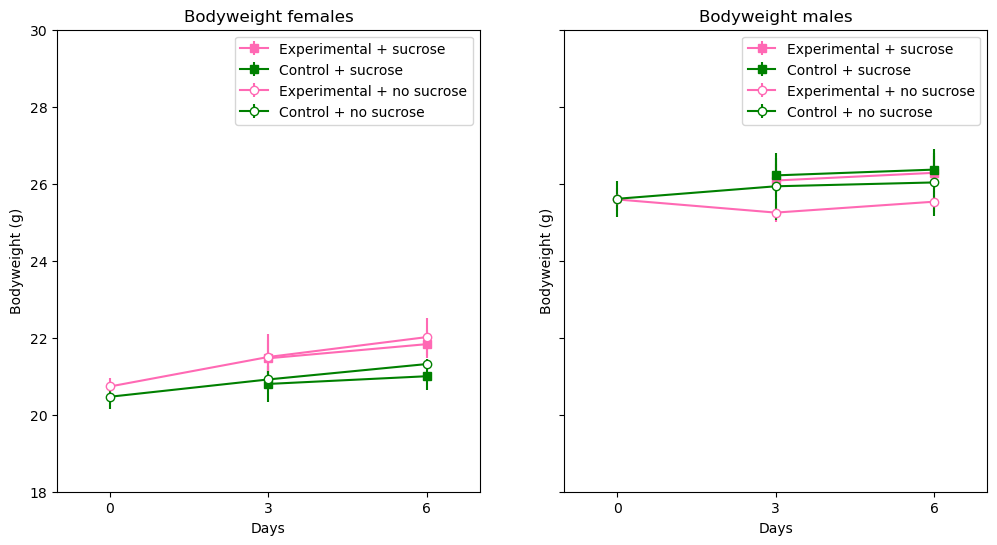

In [60]:
# Find mean and SEM of all data - body weight
mean_fw = df_food_water.groupby(["sex", "diet", "sucrose", "date"]).mean(numeric_only=True).reset_index()
sem_fw = df_food_water.groupby(["sex", "diet", "sucrose","date"]).sem(numeric_only=True).reset_index()

# Generate figure with two subplots
f, ax = plt.subplots(ncols=2, figsize=(12, 6), sharey=True,
                     gridspec_kw={"width_ratios": [1, 1]},)

# Females

# Set x values
x = np.arange(0, len(mean_fw.query("sex == 'female' and sucrose == 'Yes' and diet == 'experimental'"))*3, 3)
x = np.arange(0, len(mean_fw.query("sex == 'female' and sucrose == 'Yes' and diet == 'experimental'"))*3, 3)
x = [0,3,6]

# Plot data for each group in first subplot
ax[0].errorbar(x,
               mean_fw.query("sex == 'female' and sucrose == 'Yes' and diet == 'experimental'").bodyweight,
               yerr=sem_fw.query("sex == 'female' and sucrose =='Yes' and diet == 'control'").bodyweight,
               marker="s", markerfacecolor="hotpink", color="hotpink",
               label="Experimental + sucrose"
              )

ax[0].errorbar(x,
               mean_fw.query("sex == 'female' and sucrose == 'Yes' and diet == 'control'").bodyweight,
               yerr=sem_fw.query("sex == 'female' and sucrose =='Yes' and diet == 'control'").bodyweight,
               marker="s", markerfacecolor="green", color="green",
               label="Control + sucrose"
              )

ax[0].errorbar(x,
               mean_fw.query("sex == 'female' and sucrose == 'No' and diet == 'experimental'").bodyweight,
               yerr=sem_fw.query("sex == 'female' and sucrose == 'No' and diet == 'experimental'").bodyweight,
               marker="o", markerfacecolor="white", color="hotpink",
               label="Experimental + no sucrose"
              )

ax[0].errorbar(x,
               mean_fw.query("sex == 'female' and sucrose == 'No' and diet == 'control'").bodyweight,
               yerr=sem_fw.query("sex == 'female' and sucrose == 'No' and diet == 'control'").bodyweight,
               marker="o", markerfacecolor="white", color="green",
               label="Control + no sucrose"
              )

# Set x axis limits and ticks
ax[0].set_xlim([-1, x[-1]+1])
ax[0].set_xticks(np.arange(0, x[-1]+1, 3)) 
ax[0].set_ylim([18, 30])

# Add labels
ax[0].set_ylabel("Bodyweight (g)")
ax[0].set_xlabel("Days")
ax[0].legend()
ax[0].set_title("Bodyweight females")



# Males
x = np.arange(0, len(mean_fw.query("sex == 'male' and sucrose == 'Yes' and diet == 'experimental'"))*3, 3)
x = np.arange(0, len(mean_fw.query("sex == 'male' and sucrose == 'Yes' and diet == 'experimental'"))*3, 3)
x = [0,3,6]

# Plot data for each group in first subplot
ax[1].errorbar(x,
               mean_fw.query("sex == 'male' and sucrose == 'Yes' and diet == 'experimental'").bodyweight,
               yerr=sem_fw.query("sex == 'male' and sucrose =='Yes' and diet == 'control'").bodyweight,
               marker="s", markerfacecolor="hotpink", color="hotpink",
               label="Experimental + sucrose"
              )

ax[1].errorbar(x,
               mean_fw.query("sex == 'male' and sucrose == 'Yes' and diet == 'control'").bodyweight,
               yerr=sem_fw.query("sex == 'male' and sucrose =='Yes' and diet == 'control'").bodyweight,
               marker="s", markerfacecolor="green", color="green",
               label="Control + sucrose"
              )

ax[1].errorbar(x,
               mean_fw.query("sex == 'male' and sucrose == 'No' and diet == 'experimental'").bodyweight,
               yerr=sem_fw.query("sex == 'male' and sucrose == 'No' and diet == 'experimental'").bodyweight,
               marker="o", markerfacecolor="white", color="hotpink",
               label="Experimental + no sucrose"
              )

ax[1].errorbar(x,
               mean_fw.query("sex == 'male' and sucrose == 'No' and diet == 'control'").bodyweight,
               yerr=sem_fw.query("sex == 'male' and sucrose == 'No' and diet == 'control'").bodyweight,
               marker="o", markerfacecolor="white", color="green",
               label="Control + no sucrose"
              )

# Set x axis limits and ticks
ax[1].set_xlim([-1, x[-1]+1])
ax[1].set_xticks(np.arange(0, x[-1]+1, 3)) 
ax[1].set_ylim([18, 30])

# Add labels
ax[1].set_ylabel("Bodyweight (g)")
ax[1].set_xlabel("Days")
ax[1].legend()
ax[1].set_title("Bodyweight males")


f.savefig("..//results//bodyweight.png")

C:\Users\marije\anaconda3\Lib\site-packages\matplotlib\axes\_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
C:\Users\marije\anaconda3\Lib\site-packages\matplotlib\axes\_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])
C:\Users\marije\anaconda3\Lib\site-packages\matplotlib\axes\_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
C:\Users\marije\anaconda3\Lib\site-packages\matplotlib\axes\_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])
C:\Users\marije\anaconda3\Lib\site-packages\matplotlib\axes\_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
C:\Users\marije\anaconda3\Lib\site-packages\matplotlib\axes\_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])
C:\Users\marije\anaconda3\Lib\site-packages\matplotlib\axe

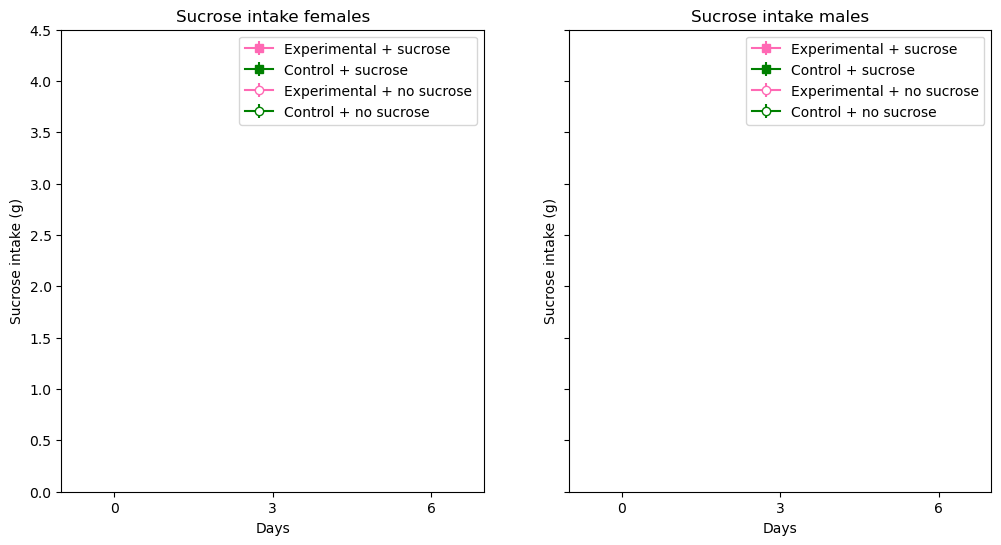

In [61]:
# Find mean and SEM of all data - food intake
mean_fw = df_food_water.groupby(["sex", "diet", "sucrose", "date"]).mean(numeric_only=True).reset_index()
sem_fw = df_food_water.groupby(["sex", "diet", "sucrose","date"]).sem(numeric_only=True).reset_index()

# Generate figure with two subplots
f, ax = plt.subplots(ncols=2, figsize=(12, 6), sharey=True,
                     gridspec_kw={"width_ratios": [1, 1]},)

# Females

# Set x values
x = np.arange(0, len(mean_fw.query("sex == 'female' and sucrose == 'Yes' and diet == 'experimental'"))*3, 3)
x = np.arange(0, len(mean_fw.query("sex == 'female' and sucrose == 'Yes' and diet == 'experimental'"))*3, 3)
x = [0,3,6]

# Plot data for each group in first subplot
ax[0].errorbar(x,
               mean_fw.query("sex == 'female' and sucrose == 'Yes' and diet == 'experimental'").sucrose_intake,
               yerr=sem_fw.query("sex == 'female' and sucrose =='Yes' and diet == 'control'").sucrose_intake,
               marker="s", markerfacecolor="hotpink", color="hotpink",
               label="Experimental + sucrose"
              )

ax[0].errorbar([xval + 0.1 for xval in x],
               mean_fw.query("sex == 'female' and sucrose == 'Yes' and diet == 'control'").sucrose_intake,
               yerr=sem_fw.query("sex == 'female' and sucrose =='Yes' and diet == 'control'").sucrose_intake,
               marker="s", markerfacecolor="green", color="green",
               label="Control + sucrose"
              )

ax[0].errorbar(x,
               mean_fw.query("sex == 'female' and sucrose == 'No' and diet == 'experimental'").sucrose_intake,
               yerr=sem_fw.query("sex == 'female' and sucrose == 'No' and diet == 'experimental'").sucrose_intake,
               marker="o", markerfacecolor="white", color="hotpink",
               label="Experimental + no sucrose"
              )

ax[0].errorbar(x,
               mean_fw.query("sex == 'female' and sucrose == 'No' and diet == 'control'").sucrose_intake,
               yerr=sem_fw.query("sex == 'female' and sucrose == 'No' and diet == 'control'").sucrose_intake,
               marker="o", markerfacecolor="white", color="green",
               label="Control + no sucrose"
              )

# Set x axis limits and ticks
ax[0].set_xlim([-1, x[-1]+1])
ax[0].set_xticks(np.arange(0, x[-1]+1, 3)) 
ax[0].set_ylim([0, 4.5])

# Add labels
ax[0].set_ylabel("Sucrose intake (g)")
ax[0].set_xlabel("Days")
ax[0].legend()
ax[0].set_title("Sucrose intake females")



# Males
x = np.arange(0, len(mean_fw.query("sex == 'male' and sucrose == 'Yes' and diet == 'experimental'"))*3, 3)
x = np.arange(0, len(mean_fw.query("sex == 'male' and sucrose == 'Yes' and diet == 'experimental'"))*3, 3)
x = [0,3,6]

# Plot data for each group in first subplot
ax[1].errorbar(x,
               mean_fw.query("sex == 'male' and sucrose == 'Yes' and diet == 'experimental'").sucrose_intake,
               yerr=sem_fw.query("sex == 'male' and sucrose =='Yes' and diet == 'control'").sucrose_intake,
               marker="s", markerfacecolor="hotpink", color="hotpink",
               label="Experimental + sucrose"
              )

ax[1].errorbar([xval + 0.1 for xval in x],
               mean_fw.query("sex == 'male' and sucrose == 'Yes' and diet == 'control'").sucrose_intake,
               yerr=sem_fw.query("sex == 'male' and sucrose =='Yes' and diet == 'control'").sucrose_intake,
               marker="s", markerfacecolor="green", color="green",
               label="Control + sucrose"
              )

ax[1].errorbar(x,
               mean_fw.query("sex == 'male' and sucrose == 'No' and diet == 'experimental'").sucrose_intake,
               yerr=sem_fw.query("sex == 'male' and sucrose == 'No' and diet == 'experimental'").sucrose_intake,
               marker="o", markerfacecolor="white", color="hotpink",
               label="Experimental + no sucrose"
              )

ax[1].errorbar(x,
               mean_fw.query("sex == 'male' and sucrose == 'No' and diet == 'control'").sucrose_intake,
               yerr=sem_fw.query("sex == 'male' and sucrose == 'No' and diet == 'control'").sucrose_intake,
               marker="o", markerfacecolor="white", color="green",
               label="Control + no sucrose"
              )

# Set x axis limits and ticks
ax[1].set_xlim([-1, x[-1]+1])
ax[1].set_xticks(np.arange(0, x[-1]+1, 3)) 
ax[1].set_ylim([0, 4.5])

# Add labels
ax[1].set_ylabel("Sucrose intake (g)")
ax[1].set_xlabel("Days")
ax[1].legend()
ax[1].set_title("Sucrose intake males")


f.savefig("..//results//sucroseintake.png")

In [ ]:
## Okay, that is not possible yet, because of the fact that all the -1 values are considered outliers because of the code
## as it is now